# Style Transfer

In [1]:
# !pip install fastcore
# !pip install timm 
# !pip install torcheval
# !pip install torch
# !pip install -U matplotlib
# !pip install datasets
# !pip install torchmetrics
# !pip install fastprogress

In [2]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from lib import *

In [3]:
# Image URLs for demos. Change as desired.
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"

In [4]:
device = 'cpu'#"mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
def download_images(url):
    imgb = fc.urlread(url, decode =False)
    return torchvision.io.decode_image(tensor(list(imgb), 
                                             dtype=torch.uint8)).float()/255.

In [6]:
contnent_im = download_images(face_url).to(device)
contnent_im.shape

torch.Size([3, 256, 256])

In [7]:
contnent_im.device

device(type='cpu')

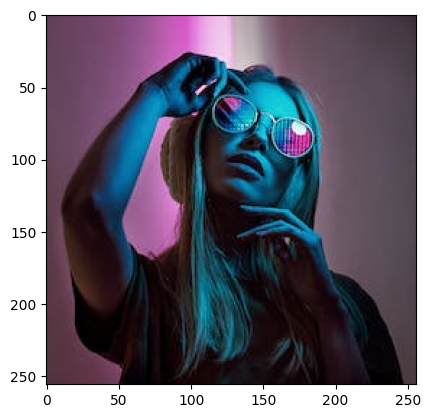

In [8]:
def show_img_(im):
    plt.imshow(im.permute(1, 2, 0))

show_img_(contnent_im)

In [9]:
contnent_im.min(),contnent_im.max() # Check bounds

(tensor(0.), tensor(1.))

# Optimizing Images

Optimize raw pixels of an img. What does this mean?
we have a single img that we want to change via optimization to match style of another img

In [10]:
class LengthDataset():
    # pyt datasets standard
    def __init__(self, length=1): 
        self.length = length
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx): 
        return 0,0


def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1),
                       DataLoader(LengthDataset(1), batch_size=1))

In [11]:
for batch in get_dummy_dls(10).train:
    print(batch)
# 10 tensors of fake data

[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]


Now we create a peculiar model: a model that uses as parameter
the data that we pass into it

In [12]:
class TensorModel(nn.Module):
    
    '''
    the actual model that we are going to train
    nn.Parameter -> pyt recognizes this as a parameter to be optimized
    optimizing direcly pixel imgs
    '''
    
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
        
    def forward(self, x=0): 
        # signature matches what the learner/TrainCB requires
        return self.t # just returns its params

In [13]:
rndm_im = torch.rand_like(contnent_im)

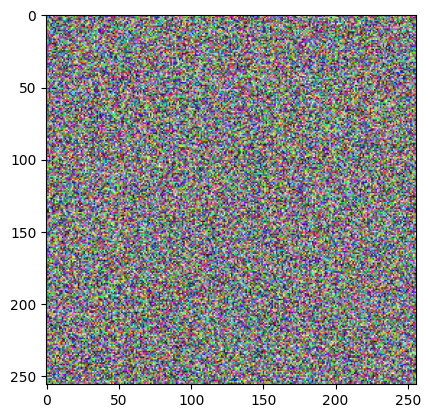

In [14]:
show_img_(torch.rand_like(contnent_im))

In [15]:
model = TensorModel(torch.rand_like(contnent_im))

In [16]:
model.t.requires_grad

True

In [17]:
list(model.parameters())[0].shape

torch.Size([3, 256, 256])

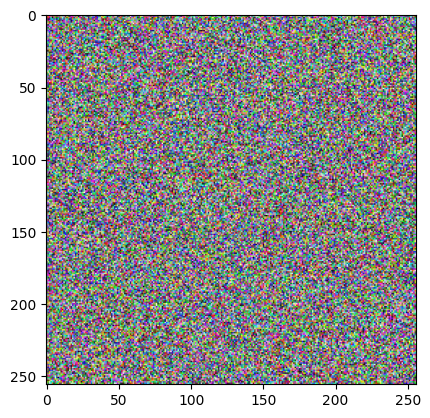

In [18]:
show_img_(model().data)

In [19]:
# not strictly required but nice to know
class ImageOptCB(TrainCB):
    def predict(self, learn):
        learn.preds = learn.model() # just returns img
    
    def get_loss(self, learn):
        # had to be overwritten cuz usually takes targets aswell
        learn.loss = learn.loss_func(learn.preds)

In [20]:
def loss_fn_mse(im):
    return F.mse_loss(im, contnent_im)

model = TensorModel(torch.rand_like(contnent_im))
cbs = [ImageOptCB(), ProgressCB(), MetricCB(), DeviceCB()]
learn = Learner(model, get_dummy_dls(100), loss_fn_mse, lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)

In [21]:
learn.fit(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


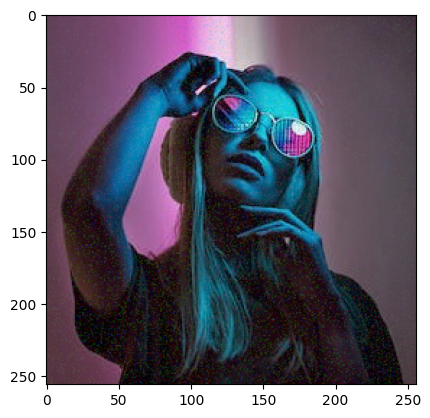

In [22]:
show_img_(model().data) # check that it works

In [23]:
class ImageLogCB(Callback):
    order = ProgressCB.order+1

    def __init__(self, log_every=10):
        self.log_every = log_every
        self.images=[]
        self.i = 0
    
    def after_batch(self, learn):
        if (self.i % self.log_every == 0):
            self.images.append(to_cpu(learn.preds.clip(0, 1).permute(1, 2, 0)))
        self.i+=1
    
    def after_fit(self, learn):
        showImgGroup(self.images[-9:], (3,3))

In [24]:
model = TensorModel(torch.rand_like(contnent_im))
cbs = [ImageLogCB(), ImageOptCB(), ProgressCB(), MetricCB(), DeviceCB()]
learn = Learner(model, get_dummy_dls(100), loss_fn_mse, lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)

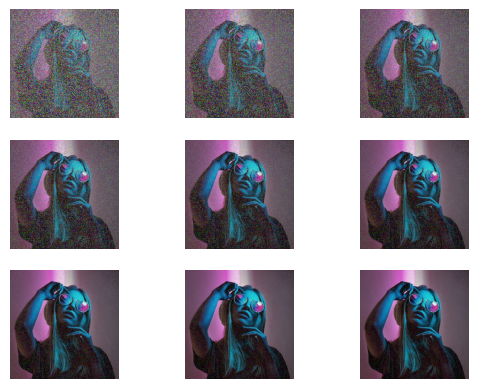

In [25]:
learn.fit(1)

# create this first super easy check so we now have full control

In [26]:
# let's now use conv layers of VGG16 as feature extractors

In [27]:
print(timm.list_models('*vgg*'))

['repvgg_a0', 'repvgg_a1', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'repvgg_d2se', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [28]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(device).features
# .features cuz we are taking only the cnn layers and discarding the 
# flattening/dataset specific task 

In [29]:
vgg16

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

## Normalize imgs
Over each channel of the data, get the means (3 values), and 3 stds and for each pixel in each img wrt each channel, normalize it 

In [30]:
means = contnent_im.mean(dim=(1,2)); means

tensor([0.2622, 0.2404, 0.3112])

In [31]:
stds = contnent_im.std(dim=(1,2)); stds

tensor([0.2133, 0.1714, 0.2212])

In [32]:
contnent_im - means / stds # let's see why error!

RuntimeError: The size of tensor a (256) must match the size of tensor b (3) at non-singleton dimension 2

In [33]:
contnent_im.shape

torch.Size([3, 256, 256])

In [34]:
means.shape

torch.Size([3])

In [35]:
# so broadcasting does not work cuz it tries to map the 3 to 256
# to make it work we need to broadcast the 3 values of the mean of each channel over each dim
means_ = means[:,None,None]; means_.shape # now we can apply broadcast 
stds_ =  stds[:,None,None]; stds_.shape

torch.Size([3, 1, 1])

In [36]:
contnent_im = contnent_im - means_ / stds_ 

In [37]:
contnent_im.shape

torch.Size([3, 256, 256])

In [38]:
# now that we have done it ourself we can use pyt thing
normalize = transforms.Normalize(mean = means, std=stds)

In [39]:
normalize(contnent_im).min()

tensor(-9.5865)

In [40]:
normalize(contnent_im).max()

tensor(-2.3038)

terminology: features == activations
btw never use list as default arg to python functions cuz they store a version of the array so if the array gets changed somewhere later on it "gets remembered" and changes the behavior of the function changes

In [41]:
# do this with hooks!! possibly with forward hooks in pytorch
# but first review custom hooks
def calc_features(imgs, target_layers=(3, 22)):
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

In [42]:
feats = calc_features(contnent_im)
[f.shape for f in feats]

# out shape: [512, 32,32], [512, 16, 16]
# the input img size has been shrunk down to 32x32 img size:
# after 3 maxpool2d the 256/2/2/2=32
# layer 17 applies 512 (3z3) filters to the img (whatever its size is)-> we take 18 after relu
# so now we try to visualize for each channel the output signal after convolution
# ie what the filter gets activated in the image
# when the filter is activated in the img -> high values in out signal
# so its just as if the out signal retains only the feature that the filter is looking for
# the feature can go from edge to eg full dog or eg face

# if we feed our img to the net and visualize  the activations of early layers we
# can see how these early layers act as edge detectors and "hd" cuz of large size 
# eg for layer 3 : [256, 256]

# while for the last layers they are more abstract concepts, not visually recognizable
# plus the imgs are 16x16 so very low dim
# meaning of last layer activation maps: deep layers aggregate feature of previous layers
# to create more complex feature detectors
# an high activation on a coarse grained img 
# in a particular channel implies the presence (in the img) of a 
# particular obj for which that channel/filter is detecting

[torch.Size([64, 256, 256]), torch.Size([512, 32, 32])]

In [43]:
len(feats)

2

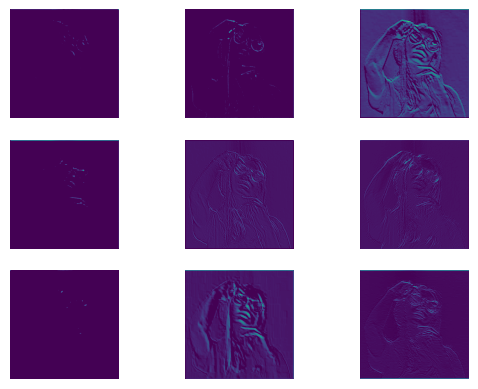

In [44]:
layer = 0
showImgGroup([feats[layer][i].unsqueeze(-1).data.cpu() for i in range (10)], (3,3))

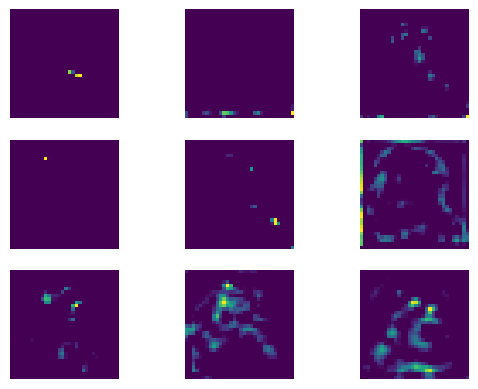

In [45]:
layer = 1
showImgGroup([feats[layer][i].unsqueeze(-1).data.cpu() for i in range(0, 10)], (3,3))

# Optimizing an Image with Content/perceptual Loss
Content/perceptual compares the content of two images by measuring similarity at a deeper level than pixel-by-pixel comparison.

It compares the feature maps of CNNs of the generated (eg wn) and reference image. 
By computing the difference between the feature maps, it measures how closely the generated image resembles the content of the reference image at a higher semantic level.

In practice, content loss is calculated by feeding both the generated and reference images through the same layers of the CNN and comparing the feature maps using a loss function, such as MSE or cosine similarity. The goal is to minimize this content loss, pushing the generated image to capture the content of the reference image without being an exact copy.

Models can produce outputs that retain the essential content of the reference image while allowing variations, as in style transfer and image transformation tasks.

In [46]:
class ContentLossToTarget():
    def __init__(self, target_im, target_layers=(18, 25)):
        ''' 
        This is a loss function
        Compute target_features maps by passing the target_im (i.e. the img with the content)
        thru the cnn 
        target_im: the img with the content
        target_layers: target_layers that we want to use to compute the content loss
        '''
        self.target_im = target_im
        self.target_layers = target_layers
        with torch.no_grad():
            self.target_features = calc_features(target_im, self.target_layers)

    def __call__(self, input_im):
        ''' computes perceptual loss '''
        features = calc_features(input_im, self.target_layers)
        return sum([(feat - targ).pow(2).mean() for feat, targ in zip(features, self.target_features)])

In [47]:
loss_func_perceptual = ContentLossToTarget(contnent_im)
model = TensorModel(torch.rand_like(contnent_im))
learn = Learner(model, get_dummy_dls(150), loss_func_perceptual, lr=1e-2, 
                cbs=cbs, opt_func= torch.optim.Adam)

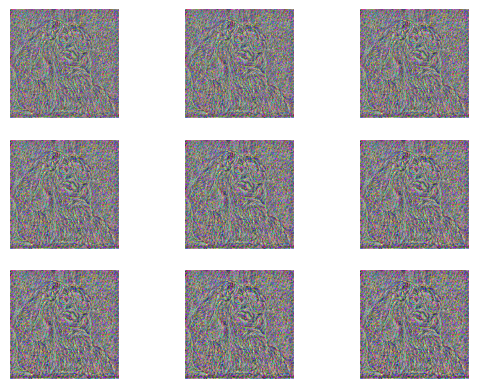

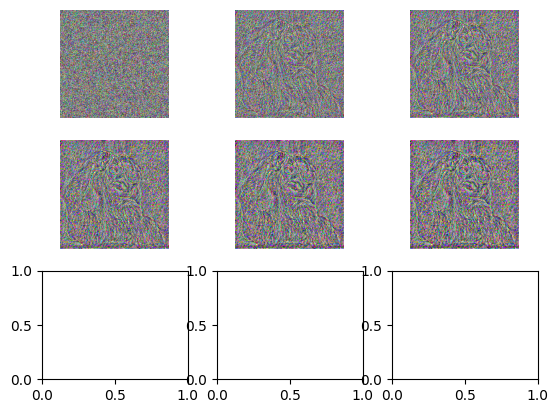

In [48]:
learn.fit(1, cbs = [ImageLogCB(log_every=30)])
# the shown output is: we "imprint" on the wn img that we feed as input the feature maps that are
# in a particular cnn layer
# for deep layers they are in noise colors cuz usually the semantic of an img is indipendent 
# from the color eg picture of a person black and white or color always person is!   
# + we are not constraining the domain of the input to be (0,255) or (0,1)

if we do the same work but trying to imprint earlier layers we get smthing way closer to the target img

In [49]:
loss_func_perceptual = ContentLossToTarget(contnent_im, target_layers=(1, 6))
model = TensorModel(torch.rand_like(contnent_im))
learn = Learner(model, get_dummy_dls(150), loss_func_perceptual, lr=1e-2, 
                cbs=cbs, opt_func= torch.optim.Adam)

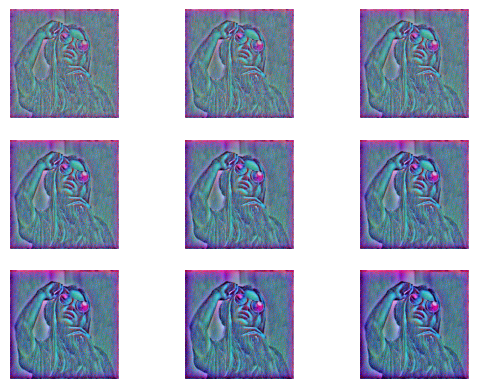

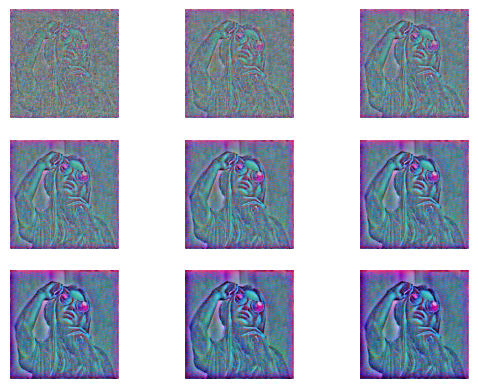

In [50]:
learn.fit(1, cbs = [ImageLogCB(log_every=15)])

Now we need to find a way to 'pass' the style from one image to another using the 'feature extraction' that we did above. We have an issue: the feature maps that we learn at early layers spatially match the features of the image: as we can see above in early layers our filters learn to extract (and consequentally to 'highlight') edges (or features more generally) that match the structure/spatial organization/locality of target feature maps (ie the feature maps obtained by passing thru the network the target image). So we need to find a way to:
- retain the feature/style/characteristics of the target image
- while not "carrying" across also the spatial component of the image (cuz otherwise they would only match).

So, we need a way to measure what kinds of style features are present, and ideally which kinds occur together, without worrying about where these features occur in the image.

To do so we use the Gram Matrix:


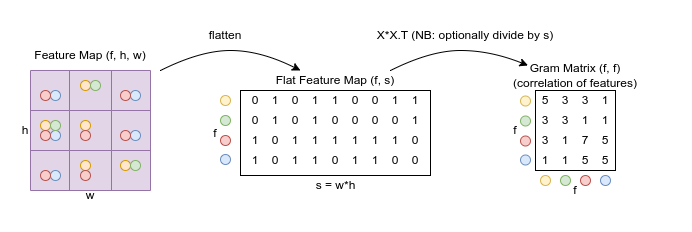

In [51]:
from IPython.display import Image
Image(filename="./gramMatrix.png")

the idea is that we flatten out each feature map, so we get w*h feature vectors
and then we compute the covariance matrix of these feature vectors (<- one feature vector for each
out_channel of the convolution). With this approach we get a out_channel x out_channel matrix in output where we practically dropped the spatial component + we get how much a feature/channel is related to another

In [52]:
def calc_gram(style_img, target_layers=(1, 6, 18, 25)):
    '''
    get feature maps of desired style
    the covariance matrix is scaled by H*W s.t. we consider normalized values instead of absolute values 
    '''
    target_features = calc_features(style_img, target_layers)
    return [(x.reshape(-1, x.shape[-1]*x.shape[-2]) @ x.reshape(-1, x.shape[-1]*x.shape[-2]).t())/ x.shape[-2]*x.shape[-1] for x in target_features]

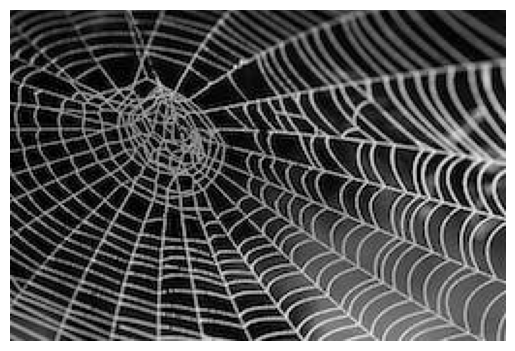

In [53]:
# let's get the style img
style_im = download_images(spiderweb_url).to(device)
show_image(style_im);

In [54]:
style_grams = calc_gram(style_im)
for i in style_grams:
    print(i.shape)

torch.Size([64, 64])
torch.Size([128, 128])
torch.Size([512, 512])
torch.Size([512, 512])


In [55]:
class SyleTransferLoss():
    def __init__(self, target_im, target_layers=(1, 6, 18, 25)):
        ''' 
        This is a loss function
        Compute target_features maps by passing the target_im (i.e. the img with the content)
        thru the cnn 
        target_im: the img with the content
        target_layers: target_layers that we want to use to compute the content loss
        now instead of targetting the activation maps themselves, we target the gram matrix
        of target image. 
        '''
        self.target_im = target_im
        self.target_layers = target_layers
        with torch.no_grad():
            self.target_features = calc_gram(target_im, self.target_layers)

    def __call__(self, input_im):
        ''' computes perceptual loss '''
        features = calc_gram(input_im, self.target_layers)
        return sum([(feat - targ).pow(2).mean() for feat, targ in zip(features, self.target_features)])

In [62]:
style_loss = SyleTransferLoss(style_im, target_layers=(1, 6, 18, 25))
loss_func_perceptual = ContentLossToTarget(contnent_im, target_layers=(1, 6, 18, 25))

def combined_loss(x):
    return style_loss(x) + loss_func_perceptual(x)

model = TensorModel(contnent_im) # we start from the source img

learn = Learner(model, get_dummy_dls(300), combined_loss, lr=2e-1, 
                cbs=cbs, opt_func= torch.optim.Adam)

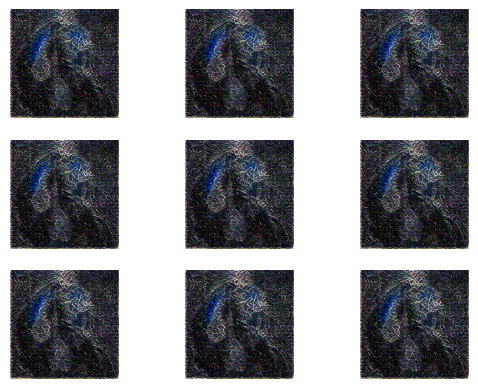

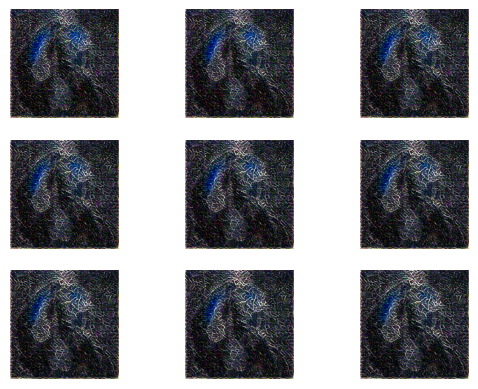

In [63]:
learn.fit(1, cbs = [ImageLogCB(log_every=15)])

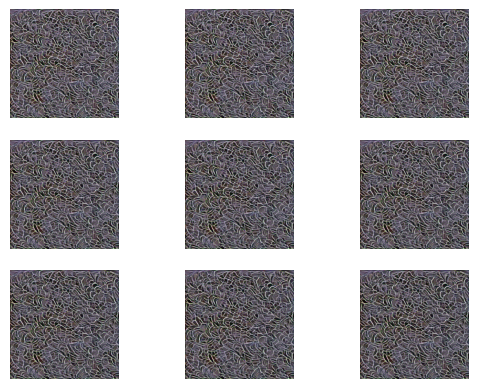

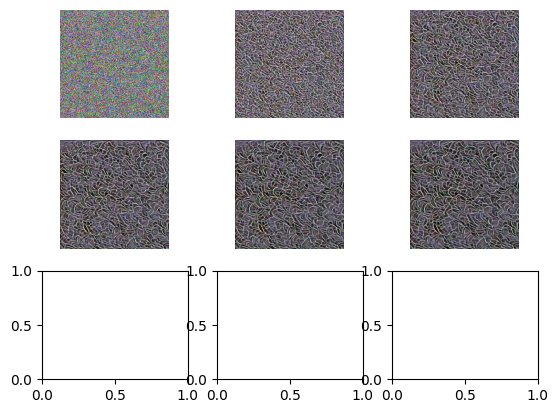

In [61]:
model = TensorModel(torch.rand_like(contnent_im))
style_loss = SyleTransferLoss(style_im)
content_loss = ContentLossToTarget(contnent_im, target_layers=(6, 18, 25))

def combined_loss(x):
    return style_loss(x) * 0.2 + content_loss(x)
    
learn = Learner(model, get_dummy_dls(300), combined_loss, lr=5e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(60)])